In [1]:
import utility
import pandas as pd
import numpy as np

import yaml
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'  # Use Computer Modern fonts
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amsfonts}'


contri = ['spearman', 'mse']

# Define color palette
palette = list(sns.color_palette("Set2")[:3]) + ['tab:cyan', 'tab:olive', 'goldenrod']

# Define the custom orders
SYSTEM_ORDER = ["CyclophilinD"]
FORCE_FIELD_ORDER = ['espaloma-0.3.1', 'gaff-2.11', 'openff-2.0.0', 'Alibay2022', 'Clark2024', 'Ries2024']
FF_NAME = {
    'espaloma-0.3.1': 'Espaloma', 
    'gaff-2.11': 'GAFF',
    'openff-2.0.0': 'OpenFF',
    # 'Lin2021': 'Lin et al. 2021',
    # 'Chen2023': 'Chen et al. 2023',
    # 'Khalak2021': 'Khalak et al. 2021',
    # 'Li2019': 'Li et al. 2019',
    'Alibay2022': 'Alibay et al. 2022',
    'Clark2024': 'Clark et al. 2024',
    'Ries2024': 'Ries et al. 2024',
}
SYSTEM_NAME = {
    "CyclophilinD": "CyclophilinD",
}


def to_latex(string):
    try:
        return r"$\mathrm{" + string.replace("_", r"\_").replace("-", r"-").replace(" ", r"\ ") + r"}$"
    except:
        raise Exception(string)



def plot_stats(ax, data, contribution='spearman', legend = 'auto'):
    dat2work = data.copy()
    
    SYSTEM_ORDER_LATEX = [to_latex(SYSTEM_NAME[s]) for s in SYSTEM_ORDER]
    FORCE_FIELD_ORDER_LATEX = [to_latex(FF_NAME[f]) for f in FORCE_FIELD_ORDER]
    
    values = dat2work[contribution].apply(utility.get_numerical_values)
    values = np.array(list(values.values))
    
    ci_low = []
    ci_high = []
    nominal_value = []
    for v, l, h in values:
        if v:
            nominal_value.append(v)
            ci_low.append(v - l)
            ci_high.append(h - v)
        else:
            nominal_value.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)

    dat2work['ci_low'] = ci_low
    dat2work['ci_high'] = ci_high
    dat2work[contribution] = nominal_value
    
    # dat2work['ci_low'] = values[:,0] - values[:,1]
    # dat2work['ci_high'] = values[:,2] - values[:,0]
    # dat2work['value'] = values[:,0]

    
    dat2work['source'] = pd.Categorical(
        dat2work['source'].replace(SYSTEM_NAME).map(to_latex), categories=SYSTEM_ORDER_LATEX, ordered=True
    )
    dat2work['force_field'] = pd.Categorical(
        dat2work['force_field'].replace(FF_NAME).map(to_latex), categories=FORCE_FIELD_ORDER_LATEX, ordered=True
    )

    # Sort the DataFrame based on the custom orders
    dat2work = dat2work.sort_values(by=['source', 'force_field']).reset_index(drop=True)

    bar_plot = sns.barplot(
        data=dat2work,
        x="source",
        y=contribution,
        hue='force_field',
        width=0.3,
        ax=ax,
        legend=legend,
        hue_order=FORCE_FIELD_ORDER_LATEX,
        palette=palette,
        order=SYSTEM_ORDER_LATEX
    )

    # Those are the patch used on the legend and attached at the end
    num_unique_ff = len(dat2work["force_field"].unique())
    # [:-num_unique_ff] ensures that only the patches of the real bars are considered
    if legend:
        bar_positions = sorted([patch.get_x() + patch.get_width() / 2 for patch in bar_plot.patches[:-num_unique_ff]])
    else:
        bar_positions = sorted([patch.get_x() + patch.get_width() / 2 for patch in bar_plot.patches])
    dat2work.dropna(inplace=True)
    ax.errorbar(
        x=bar_positions,  # Position of the bar
        y=dat2work[contribution],
        yerr=[dat2work['ci_low'], dat2work['ci_high']],
        fmt='none',  # No marker
        c='gray',
        capsize=5
    )
    
    if contribution == 'pearson':
        ax.set(
            ylabel=r'$\rho$'
        )
    if contribution == 'spearman':
        ax.set(
            ylabel=r'$r_S$'
        )
    if contribution == 'kendall':
        ax.set(
            ylabel=r'$\tau$'
        )
        
    ax.set(xlabel='')


def plot_ff(ax, data, contribution, legend = None):
    
    dat2work = data.copy()
    
    SYSTEM_ORDER_LATEX = [to_latex(SYSTEM_NAME[s]) for s in SYSTEM_ORDER]
    FORCE_FIELD_ORDER_LATEX = [to_latex(FF_NAME[f]) for f in FORCE_FIELD_ORDER]
    
    dat2work['source'] = pd.Categorical(
        dat2work['source'].replace(SYSTEM_NAME).map(to_latex), categories=SYSTEM_ORDER_LATEX, ordered=True
    )
    dat2work['force_field'] = pd.Categorical(
        dat2work['force_field'].replace(FF_NAME).map(to_latex), categories=FORCE_FIELD_ORDER_LATEX, ordered=True
    )
    
    # Sort the DataFrame based on the custom orders
    dat2work = dat2work.sort_values(by=['source', 'force_field']).reset_index(drop=True)

    sns.boxplot(
        x="source",
        y=contribution,
        hue='force_field',
        data=dat2work,
        whis=1.5, #[0, 100],
        width=0.3,
        ax=ax,
        legend=legend,
        hue_order=FORCE_FIELD_ORDER_LATEX,
        palette=palette,
        order=SYSTEM_ORDER_LATEX
    )
    if contribution == 'diff':
        ax.set(
            ylabel=r'$\Delta G_\mathrm{calc} - \Delta G_\mathrm{exp} \mathrm{~[kcal/mol]}$'
        )

    ax.set(xlabel='')

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [2]:
CALC_TYPE = "mbar"

BindFlowData = pd.read_csv("../data/simulation/bindflow/gather/BindFlow.csv")

columns = [
    "system",
    "ligand",
    "replica",
    "sample",
    "exp_dG",
    "exp_dG_error",
    f"simulation_{CALC_TYPE}_espaloma-0.3.1",
    f"simulation_{CALC_TYPE}_gaff-2.11",
    f"simulation_{CALC_TYPE}_openff-2.0.0",
    "simulation_Alibay2022",
    "simulation_Clark2024",
    "error_Clark2024",
    "simulation_Ries2024",
    "error_Ries2024",
]

BindFlowData = BindFlowData[columns]


BindFlowData.rename(
    columns={
        "system": "source",
        f"simulation_{CALC_TYPE}_espaloma-0.3.1": "simulation_espaloma-0.3.1",
        f"simulation_{CALC_TYPE}_gaff-2.11": "simulation_gaff-2.11",
        f"simulation_{CALC_TYPE}_openff-2.0.0": "simulation_openff-2.0.0",
    },
    inplace=True
)

# Only consider 3 replicas
BindFlowData = BindFlowData[BindFlowData["replica"] <= 3]

mean = BindFlowData.groupby(["source", "ligand"]).mean().reset_index().drop(columns=["replica", "sample"])
sem = BindFlowData.groupby(["source", "ligand"]).sem().reset_index().drop(columns=["replica", "sample"])

# Filter DataFrame
mask = mean["simulation_espaloma-0.3.1"].notna() & mean["simulation_Alibay2022"].notna() & mean["simulation_Clark2024"].notna() & mean["simulation_Ries2024"].notna()


mean = mean[mask]
sem = sem[mask]

sem.rename(
    columns={
        "simulation_espaloma-0.3.1": "sem_espaloma-0.3.1",
        "simulation_gaff-2.11": "sem_gaff-2.11",
        "simulation_openff-2.0.0": "sem_openff-2.0.0",
        "simulation_Alibay2022": "sem_Alibay2022",
    },
    inplace=True
)

sem.drop(columns=["exp_dG", "exp_dG_error", "simulation_Clark2024", "error_Clark2024", "simulation_Ries2024", "error_Ries2024"], inplace=True)
sem["sem_Clark2024"] = mean["error_Clark2024"]
sem["sem_Ries2024"] = mean["error_Ries2024"]
mean.drop(columns=["error_Clark2024", "error_Ries2024"], inplace=True)

df_merge = pd.merge(mean, sem, on=["source", "ligand"])
df_merge["sem_Li2019"] = 0
df_merge




,source,ligand,exp_dG,exp_dG_error,simulation_espaloma-0.3.1,simulation_gaff-2.11,simulation_openff-2.0.0,simulation_Alibay2022,simulation_Clark2024,simulation_Ries2024,sem_espaloma-0.3.1,sem_gaff-2.11,sem_openff-2.0.0,sem_Alibay2022,sem_Clark2024,sem_Ries2024,sem_Li2019
0,CyclophilinD,ligand-14,-11.22,0.0,-14.328635,-9.987262,-14.271806,-12.663333,-14.38,-13.10,0.527543,1.112319,0.344406,0.127192,2.17,0.72,0
1,CyclophilinD,ligand-16,-8.42,0.0,-14.862085,-8.196963,-9.917198,-10.643333,-9.27,-12.72,0.834837,0.805273,0.809458,0.362231,1.79,0.39,0
2,CyclophilinD,ligand-2,-9.06,0.0,-13.081668,-8.623902,-11.850227,-8.073333,-10.56,-8.41,0.623070,0.214710,0.204344,0.163333,1.06,1.91,0
3,CyclophilinD,ligand-27,-7.57,0.0,-8.448300,-9.564269,-12.227682,-9.973333,-9.14,-9.59,1.247018,1.169711,1.144482,0.836866,1.67,0.55,0
4,CyclophilinD,ligand-3,-2.93,0.0,-4.502895,-4.282856,-3.812680,-4.783333,-5.06,-4.24,0.395899,0.068741,0.882603,0.065659,2.78,0.59,0
5,CyclophilinD,ligand-39,-8.43,0.0,-11.110168,-9.480078,-10.581944,-12.373333,-13.99,-12.02,1.207778,0.791682,0.926543,0.265477,1.97,0.11,0
6,CyclophilinD,ligand-4,-2.90,0.0,-5.405915,-5.456303,-3.772138,-3.716667,-4.92,-2.55,0.620381,1.218012,1.038002,0.413777,1.92,0.67,0
7,CyclophilinD,ligand-40,-8.08,0.0,-9.229526,-8.880234,-8.833196,-11.630000,-14.72,-11.11,0.491938,0.556643,1.365959,0.263881,0.88,0.37,0
8,CyclophilinD,ligand-8,-4.04,0.0,-6.382864,-6.760397,-7.387541,-7.393333,-7.30,-7.16,2.302041,0.395745,0.532277,0.121152,0.73,0.55,0


In [3]:
replicates = 10_000
confidence = 68


stats_data = pd.DataFrame()
for system in SYSTEM_ORDER:
    system_name = SYSTEM_NAME[system]
    df = utility.get_all_stats(df_merge[df_merge["source"] == system], replicates=replicates, confidence=confidence)
    df["source"] = system_name
    stats_data = pd.concat([stats_data, df])
stats_data["force_field"] = [s.split("simulation_")[-1] for s in stats_data.index]

diff_data = df_merge[["source",	"ligand"]]
for column in df_merge.columns:
    if column.startswith("simulation_"):
        ff = column.split("simulation_")[-1]
        diff_data[ff] =  df_merge[column] - df_merge["exp_dG"]

diff_data

diff_data = pd.melt(
    diff_data,
    id_vars=["source", "ligand"],  # Columns to keep fixed
    var_name="force_field",                   # Name for the new "variable" column
    value_name="diff"                  # Name for the new "value" column
)

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
/var/folders/fl/txtwcjh94vs_gkm_s21h8w7m0000gn/T/ipykernel_18014/47754957.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

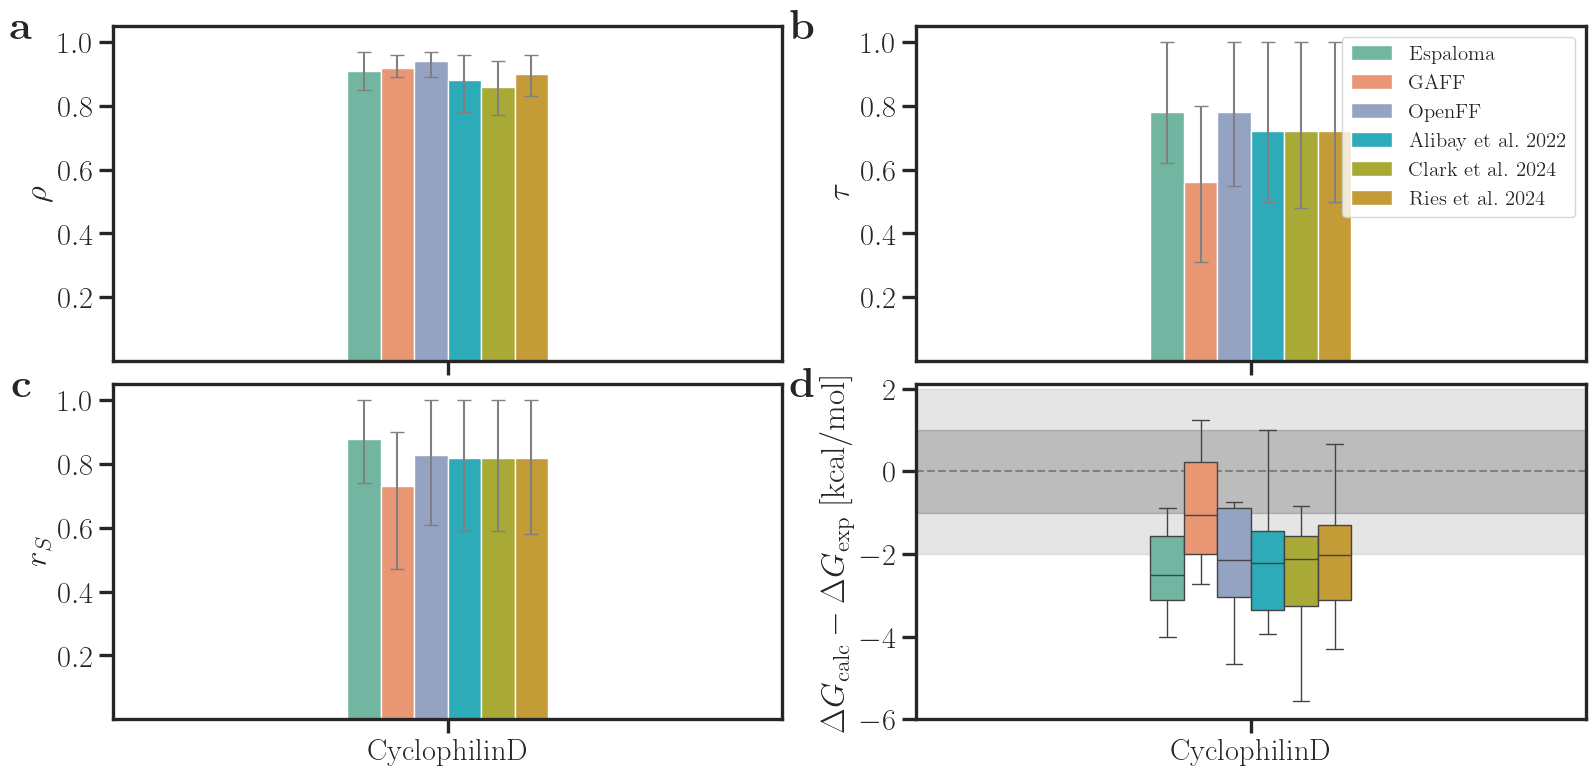

In [4]:
scale = 2  
sns.set_theme(
    style="ticks", 
    font_scale=scale,
    rc={
        "axes.linewidth": 1.2 * scale,
        # "lines.linewidth": 1.1 * scale
        }
)

# Make ticks thicker/longer in proportion to font scaling
plt.rcParams.update({
    "xtick.major.size": 5 * scale,   # length of major ticks
    "ytick.major.size": 5 * scale,
    "xtick.major.width": 1.2 * scale,  # thickness of major ticks
    "ytick.major.width": 1.2 * scale,
})
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(19, 9), sharex=True)

plot_stats(ax=axs[0,0],data=stats_data, contribution='pearson', legend=None)

plot_stats(ax=axs[0,1],data=stats_data, contribution='kendall', legend="auto")

plot_stats(ax=axs[1,0],data=stats_data, contribution='spearman', legend=None)


axs[0, 1].sharey(axs[0, 0])
axs[1, 0].sharey(axs[0, 0])
axs[0,0].set(ylim=[0,1.05])
axs[0,0].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
axs[0,1].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
axs[1,0].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])


axs[1,1].axhline(0, color='gray', linestyle='--')

plot_range = [-1*v for v in range(5, 1, -1)] + list(range(15))
axs[1,1].fill_between(plot_range, -1, 1, color='black', alpha=0.2,)#label=r'$\pm 1 \mathrm{~kcal/mol}$')
axs[1,1].fill_between(plot_range, -2, 2, color='gray', alpha=0.2,)#label=r'$\pm 2 \mathrm{~kcal/mol}$')


plot_ff(ax=axs[1,1], data=diff_data,contribution='diff', legend=None)
axs[0,1].get_legend().set_title(None)
axs[0,1].legend(ncol=1, loc='upper right', fontsize=15)  # Adjust legend position if needed
axs[1,1].set(ylim=(-6, 2.1))

# Add subplot labels
labels = ['a', 'b', 'c', 'd']
for ax, label in zip(axs.flat, labels):
    if label in ['b', 'd']:
        if any(axs[1,1].get_yticks() <= -10):
            x_position = -0.2
            wspace = 0.25
        else:
            x_position = -0.15
            wspace = 0.2
    else:
        x_position = -0.12
    
    ax.text(x_position, 1.05, f"$\\mathbf{{{label}}}$", transform=ax.transAxes, 
            fontsize=30, va='top', ha='right')

fig.subplots_adjust(wspace=wspace, hspace=0.07)

fig.savefig('summary/external/mbar-stats-CyclophilinD-validation.pdf',
            bbox_inches="tight",
            pad_inches=0.05,
            transparent=False)
